# Variability of dissolved inorganic carbon in the largest karst estuarine lagoon system of the southern Gulf of Mexico

### José Andrés Martínez-Trejo<sup>1</sup>, Jose-Gilberto Cardoso-Mohedano<sup>2,*</sup>, Joan Albert Sanchez-Cabeza<sup>3</sup>, José Martin Hernández Ayón<sup>4</sup>, Ana Carolina Ruiz-Fernández<sup> 3 </sup>, Mario Alejandro Gómez-Ponce <sup>2</sup> , Linda Barranco-Servín<sup>5</sup>, Daniel Pech<sup>5</sup>

<sup> 1 </sup> Posgrado en Ciencias del Mar y Limnología, Universidad Nacional Autónoma de México; Avenida Ciudad Universitaria 3000, C.P. 04510, Coyoacán, Ciudad de México, México

<sup> 2 </sup>  Estación el Carmen, Instituto de Ciencias del Mar y Limnología, Universidad Nacional Autónoma de México, Carretera Carmen-Puerto Real km. 9.5, 24157 Ciudad del Carmen, Campeche, México

<sup> 3 </sup>  Unidad Académica Mazatlán, Instituto de Ciencias del Mar y Limnología, Universidad Nacional Autónoma de México, Calzada Joel Montes Camarena s/n, Colonia Playa Sur, Mazatlán 82000, Sinaloa, México

<sup> 4 </sup>  Instituto de Investigaciones Oceanológicas, Universidad Autónoma de Baja California, Km. 103 CarreteraTijuana-Ensenada, Ensenada, Baja California, México

<sup> 5 </sup> Laboratorio de Biodiversidad Marina y Cambio Climático (BIOMARCCA), El Colegio de la Frontera Sur, Lerma, Campeche, México. 

 \*Corresponding Author: gcardoso@cmarl.unam.mx Phone:+52-938-38-31847

[doi:XXXXX](https://XXXX)


- Raw data are aviable in: 

https://metadata.icmyl.unam.mx/bitstream/handle/20.500.12201/11367/MartinezTrejo_etal_2023_TA_DIC_RawData.csv?sequence=1&isAllowed=y



In [18]:
# Import packages
import pandas as pd
import PyCO2SYS as pyco2
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats


- Read csv  data file

In [19]:
# Function to read in csv file
def read_csv(file):
    """
    Read in csv file and return pandas dataframe
    """
    df = pd.read_csv(file, sep=",", header=0,  decimal=".", encoding='utf-8')
    return df

In [20]:
# define file path 
terminos_ta_dic_data_path = "../data/MartinezTrejo_etal_2023_TA_DIC_RawData.csv"

# Read in data
terminos_ta_dic_raw = read_csv(terminos_ta_dic_data_path)

# Copy raw data to new dataframe
terminos_ta_dic = terminos_ta_dic_raw.copy()

# Delete the raw DataFrame
del terminos_ta_dic_raw


### Calculate  [TA - DIC] and Apparent Oxygen Utilization (AOU)

In [21]:
# Calculate TA - DIC (TA-DIC)  
terminos_ta_dic["TA-DIC"] = terminos_ta_dic["TA_micromol_kg"] - terminos_ta_dic["DIC_micromol_kg"]

# Convert DO from mg/L to micromol/kg
terminos_ta_dic["DO_micromol_kg"] = convert_oxygen_concentration(terminos_ta_dic["DO_mg_L"], 
                                                                terminos_ta_dic["Sal_psu"], terminos_ta_dic["Temp_C"], pressure=0) 
# Calculate Apparent Oxygen Utilization (AOU)
terminos_ta_dic["oxygen_utilization_micromol_kg"] = calculate_aou(terminos_ta_dic["Sal_psu"], terminos_ta_dic["Temp_C"],  
                                                                  0.0, terminos_ta_dic["DO_micromol_kg"], terminos_ta_dic["latitude"], 
                                                                  terminos_ta_dic["latitude"] )


## PyCO2SYS configuration from estuarine waters (Humphreys et al. 2022)

In [22]:
# Copy data to new dataframe
terminos_inorganic_carbon = terminos_ta_dic.copy()

# Create dictionary with data configuration for PyCO2SYS. 
# For more information on the parameters see Humphreys et al (2022)
my_co2sys_params_dic_ta_config = {
    # DIC measured in the lab in μmol/kg-sw
    "par1": terminos_inorganic_carbon["DIC_micromol_kg"],
    # TA measured in the lab, Total scale
    "par2": terminos_inorganic_carbon["TA_micromol_kg"],
    "par1_type": 2,         # tell PyCO2SYS: "par2 is a DIC value"
    "par2_type": 1,         # tell PyCO2SYS: "par1 is a TA value"
    # Fields conditions
    "salinity": terminos_inorganic_carbon["Sal_psu"],  # in-situ salinity in PSU
    # in-situ temperature (output conditions) in °C
    "temperature_out": terminos_inorganic_carbon["Temp_C"],
    "pressure_out": 0.0,
    # Settings
    "opt_pH_scale": 1,     # Total pH (Wolf-Gladrow et al. 2007)
    "opt_k_carbonic": 15,     # 0 < T < 50 °C, 1 < S < 50, Seawater scale, real seawater (Millero F.J. 2010)
    "temperature": 25      # lab temperature (input conditions) in °C
}

### Run PyCO2SYS

In [23]:
# Run PyCO2SYS to calculate the carbonate system parameters
terminos_inorganic_carbon_results= pyco2.sys(**my_co2sys_params_dic_ta_config)

### Read the interes variables from PYCO2sys 

In [24]:
# Select variables of interest from the PyCO2SYS output and concatenate with the original dataframe
CarbonateTL = pd.concat([
       terminos_ta_dic, 
       pd.DataFrame({key: terminos_inorganic_carbon_results[key] for key in [
              "pH", 
              "saturation_aragonite", 
              "pCO2_out", 
              "k_aragonite", 
              "total_calcium", 
              "carbonate" 
       ]})
], axis=1)

In [25]:
# Calculate the apparent oxygen utilization (AOU) in micromol/kg using the function calculate_aou
CarbonateTL["oxygen_utilization_micromol_kg"] = calculate_aou(CarbonateTL["Sal_psu"], CarbonateTL["Temp_C"],  0.0, CarbonateTL["DO_micromol_kg"], CarbonateTL["latitude"] , CarbonateTL["latitude"] )


- Select Candelaria and Palizada results

In [26]:
CandelariaResult = CarbonateTL.loc[CarbonateTL["Estuary"] == "Candelaria"]
                     
PalizadaResult = CarbonateTL.loc[CarbonateTL["Estuary"] == "Palizada"]

- TA vs DIC Perform  least squares (OLS) regression

In [31]:
#define predictor and response variables
x = CarbonateTL['TA_micromol_kg']
y = CarbonateTL['DIC_micromol_kg']

#add constant to predictor variables
x = sm.add_constant(x)

#fit linear regression model
model = sm.OLS(y, x).fit()

#view model summary
print(model.summary())

# export model summary to text file
with open('../output_files/TA_DIC_liner_model_summary.txt', 'w') as file:
    file.write(model.summary().as_text())

                            OLS Regression Results                            
Dep. Variable:        DIC_micromol_kg   R-squared:                       0.924
Model:                            OLS   Adj. R-squared:                  0.924
Method:                 Least Squares   F-statistic:                     1222.
Date:                Mon, 06 May 2024   Prob (F-statistic):           7.26e-58
Time:                        11:46:23   Log-Likelihood:                -647.75
No. Observations:                 102   AIC:                             1299.
Df Residuals:                     100   BIC:                             1305.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const           -247.0395     88.497     -2.

- TA vas DIC linear Equation

In [32]:
# Calculate the linear regression parameters for TA and DIC
linear_params = model.params

standard_errors = model.bse

Lintercep = f" {linear_params.iloc[0]:.0f}( \pm {standard_errors.iloc[0]:.0f})"

LSlope = f"{linear_params.iloc[1]:.2f}( \pm {standard_errors.iloc[1]:.2f})"

linearEquation= f"$y = {LSlope} \cdot x{Lintercep}$"

Rsquared = f"$r^{2}$ = {model.rsquared:.3f}"

- TA vs DIC , scatter plot  with linear regretion

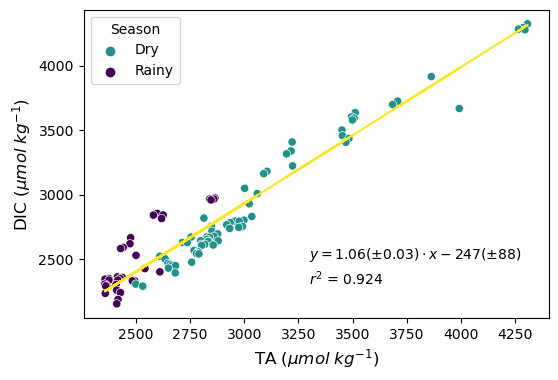

In [33]:
# Plot the relationship between TA and DIC
x = CarbonateTL['TA_micromol_kg']
y = CarbonateTL['DIC_micromol_kg']

# Plot 
g = sns.scatterplot(
    data=CarbonateTL,
    x="TA_micromol_kg", y="DIC_micromol_kg", hue="Season",
    palette=dict(Dry="#21918c", Rainy="#440154")
)

# Add labels and title
plt.xlabel('TA ($\mu mol  \; kg^{-1}$)', fontsize = 12)

plt.ylabel('DIC ($\mu mol  \; kg^{-1}$)', fontsize = 12)

# Calculate the linear regression line
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)

# Plot linear regression 

plt.plot(x, intercept + slope*x, '#fde725')

# set the figure size
plt.gcf().set_size_inches(6, 4)



plt.text(3300, 2500, linearEquation)

plt.text(3300, 2300, Rsquared)


# save the plot as a PDF file paper format  
plt.savefig('../output_files/DIC_TA.pdf', dpi=300, bbox_inches='tight')

plt.show()


_____________

-Salinity vs TA ,  Perform  least squares (OLS) regression

In [39]:
import statsmodels.api as sm

#define predictor and response variables
x = CarbonateTL['Sal_psu']
y = CarbonateTL['TA_micromol_kg']

#add constant to predictor variables
x = sm.add_constant(x)

#fit linear regression model
model = sm.OLS(y, x).fit()

#view model summary
print(model.summary())

# export model summary to text file
with open('../output_files/Sal_TA_liner_model_summary.txt', 'w') as file:
    file.write(model.summary().as_text())

                            OLS Regression Results                            
Dep. Variable:         TA_micromol_kg   R-squared:                       0.143
Model:                            OLS   Adj. R-squared:                  0.134
Method:                 Least Squares   F-statistic:                     16.64
Date:                Mon, 06 May 2024   Prob (F-statistic):           9.09e-05
Time:                        11:58:21   Log-Likelihood:                -761.71
No. Observations:                 102   AIC:                             1527.
Df Residuals:                     100   BIC:                             1533.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       3100.8009     67.745     45.771      0.0

-Salinity  vs TA , scatter plot  with linear regretion

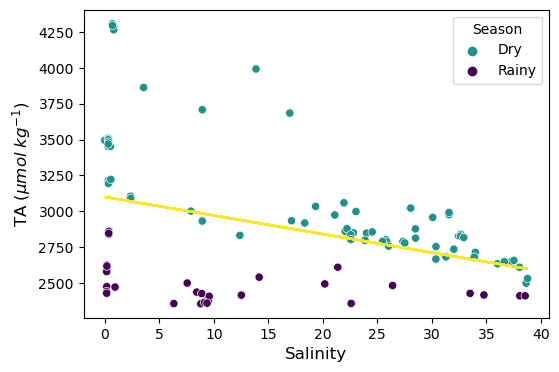

r-squared: 0.142669985748218
Intercept: 3100.800893344719
Slope: -12.916852281816311


In [40]:
import matplotlib.pyplot as plt
from scipy import stats

x = CarbonateTL['Sal_psu']
y = CarbonateTL['TA_micromol_kg']
import seaborn as sns



# Plot sepal width as a function of sepal_length across days
g = sns.scatterplot(
    data=CarbonateTL,
    x="Sal_psu", y="TA_micromol_kg", hue="Season",
    palette=dict(Dry="#21918c", Rainy="#440154")
)


#plt.scatter(x, y, label='original data', color = "#3b528b")

# Add labels and title
plt.xlabel('Salinity', fontsize = 12)

plt.ylabel('TA ($\mu mol  \; kg^{-1}$)', fontsize = 12)

# Calculate the linear regression line
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)

# Plot linear regression 

plt.plot(x, intercept + slope*x, '#fde725')

# set the figure size
plt.gcf().set_size_inches(6, 4)

# save the plot as a PDF file paper format 
plt.savefig('../output_files/SAL_TA.tiff', dpi=300, bbox_inches='tight')

plt.show()

# Print linear regression results 

print("r-squared:", r_value**2)
print("Intercept:", intercept)
print("Slope:", slope)

____________________________________________

-Salinity vs DIC ,  Perform  least squares (OLS) regression

In [41]:
import statsmodels.api as sm

#define predictor and response variables
x = CarbonateTL['Sal_psu']
y = CarbonateTL['DIC_micromol_kg']

#add constant to predictor variables
x = sm.add_constant(x)

#fit linear regression model
model = sm.OLS(y, x).fit()

#view model summary
print(model.summary())

# export model summary to text file
with open('../output_files/Sal_DIC_liner_model_summary.txt', 'w') as file:
    file.write(model.summary().as_text())

                            OLS Regression Results                            
Dep. Variable:        DIC_micromol_kg   R-squared:                       0.323
Model:                            OLS   Adj. R-squared:                  0.316
Method:                 Least Squares   F-statistic:                     47.67
Date:                Mon, 06 May 2024   Prob (F-statistic):           4.71e-10
Time:                        11:59:17   Log-Likelihood:                -759.53
No. Observations:                 102   AIC:                             1523.
Df Residuals:                     100   BIC:                             1528.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       3165.3265     66.313     47.733      0.0

- Salinity  vs DIC , scatter plot  with linear regretion

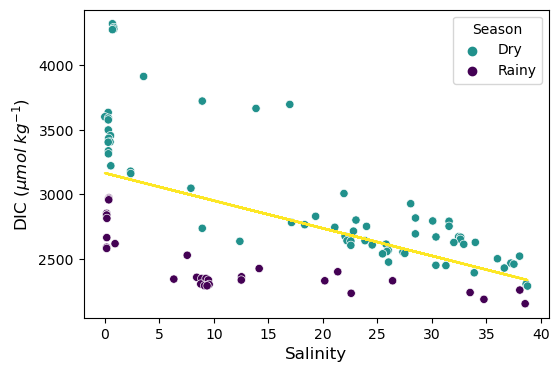

r-squared: 0.3228084313475949
Intercept: 3165.3264755206874
Slope: -21.39938964424291


In [42]:
import matplotlib.pyplot as plt
from scipy import stats

x = CarbonateTL['Sal_psu']
y = CarbonateTL['DIC_micromol_kg']
import seaborn as sns



# Plot sepal width as a function of sepal_length across days
g = sns.scatterplot(
    data=CarbonateTL,
    x="Sal_psu", y="DIC_micromol_kg", hue="Season",
    palette=dict(Dry="#21918c", Rainy="#440154")
)


#plt.scatter(x, y, label='original data', color = "#3b528b")

# Add labels and title
plt.xlabel('Salinity', fontsize = 12)

plt.ylabel('DIC ($\mu mol  \; kg^{-1}$)', fontsize = 12)

# Calculate the linear regression line
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)

# Plot linear regression 

plt.plot(x, intercept + slope*x, '#fde725')



# set the figure size
plt.gcf().set_size_inches(6, 4)

# save the plot as a PDF file paper format 
plt.savefig('../output_files/SAL_DIC.pdf', dpi=300, bbox_inches='tight')

plt.show()

# Print linear regression results 

print("r-squared:", r_value**2)
print("Intercept:", intercept)
print("Slope:", slope)

-TA vs DIC ,  Perform  least squares (OLS) regression

-Salinity  vs TA , scatter plot  with linear regretion

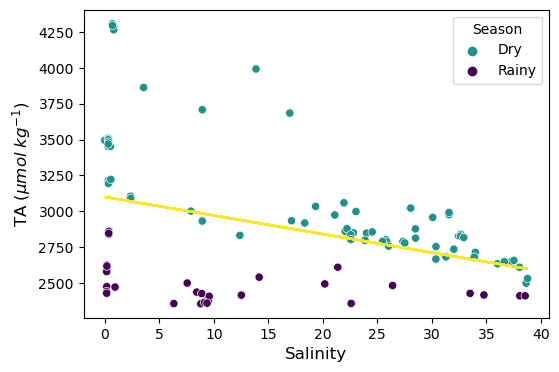

r-squared: 0.142669985748218
Intercept: 3100.800893344719
Slope: -12.916852281816311


In [36]:
# plot the linear regression model 

x = CarbonateTL['Sal_psu']
y = CarbonateTL['TA_micromol_kg']
import seaborn as sns



# Plot sepal width as a function of sepal_length across days
g = sns.scatterplot(
    data=CarbonateTL,
    x="Sal_psu", y="TA_micromol_kg", hue="Season",
    palette=dict(Dry="#21918c", Rainy="#440154")
)


#plt.scatter(x, y, label='original data', color = "#3b528b")

# Add labels and title
plt.xlabel('Salinity', fontsize = 12)

plt.ylabel('TA ($\mu mol  \; kg^{-1}$)', fontsize = 12)

# Calculate the linear regression line
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)

# Plot linear regression 

plt.plot(x, intercept + slope*x, '#fde725')

# set the figure size
plt.gcf().set_size_inches(6, 4)

# save the plot as a PDF file paper format 
plt.savefig('../output_files/SAL_TA.pdf', dpi=300, bbox_inches='tight')

plt.show()

# Print linear regression results 

print("r-squared:", r_value**2)
print("Intercept:", intercept)
print("Slope:", slope)

-Salinity vs DIC ,  Perform  least squares (OLS) regression

In [ ]:
#define predictor and response variables
x = CarbonateTL['Sal_psu']
y = CarbonateTL['DIC_micromol_kg']

#add constant to predictor variables
x = sm.add_constant(x)

#fit linear regression model
model = sm.OLS(y, x).fit()

#view model summary
print(model.summary())

# export model summary to text file
with open('../output_files/Sal_DIC_liner_model_summary.txt', 'w') as file:
    file.write(model.summary().as_text())

-Salinity vs TA ,  Perform  least squares (OLS) regression

In [ ]:
import statsmodels.api as sm

#define predictor and response variables
x = CarbonateTL['Sal_psu']
y = CarbonateTL['TA_micromol_kg']

#add constant to predictor variables
x = sm.add_constant(x)

#fit linear regression model
model = sm.OLS(y, x).fit()

#view model summary
print(model.summary())

# export model summary to text file
with open('../output_files/Sal_TA_liner_model_summary.txt', 'w') as file:
    file.write(model.summary().as_text())

### [TA - DIC] analysis in the TL lagoon system of the southern Gulf of Mexico

Plot [DIC-TA],  Salinity and pH by Estuary 

In [ ]:
# Plot [TA-DIC] as a function of salinity across estuaries, colobar represents pH
# getting the original colormap using cm.get_cmap() function
orig_map = plt.colormaps.get_cmap('viridis')

# reversing the original colormap using reversed() function
reversed_map = orig_map.reversed()

scatter = plt.scatter(
    x=CandelariaResult["Sal_psu"], y=CandelariaResult["TA-DIC"], c=CandelariaResult["pH"], cmap=reversed_map,
    marker='.', s= 300, label='Candelaria', alpha=0.9)

scatter = plt.scatter(
    x=PalizadaResult["Sal_psu"], y=PalizadaResult["TA-DIC"], c=PalizadaResult["pH"], cmap=reversed_map,
    marker='+', s= 300, label='Palizada', alpha=0.9)

# Add a constant line at zero on the y-axis
plt.axhline(0, color='k', linestyle='--', alpha=0.5)

# Add a color bar
plt.colorbar(scatter)

# Add labels and title
plt.xlabel('Salinity', fontsize = 12)
plt.ylabel("[TA-DIC] ($\mu mol  \; kg^{-1}$)" , fontsize = 12)
plt.legend(loc='lower right')

# set the figure size
plt.gcf().set_size_inches(6, 4)

# save the plot as a PDF file
plt.savefig('../output_files/sal_DIC-TA_pH.pdf', dpi=300, bbox_inches='tight')

# display the plot
plt.show()



_________________

- [TA-DIC] vs pH, and salinity as color, for Candelaria and Palizada estuaries

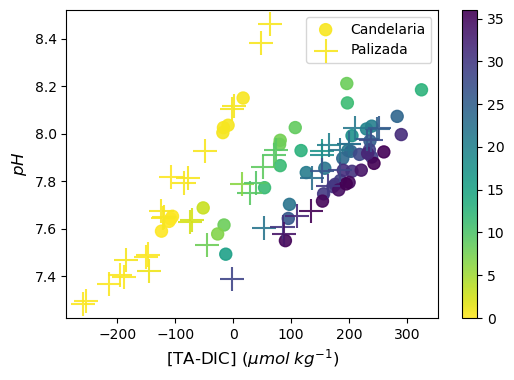

In [45]:
# Create the scatter plot 

# getting the original colormap using cm.get_cmap() function
orig_map = plt.colormaps.get_cmap('viridis')

# reversing the original colormap using reversed() function
reversed_map = orig_map.reversed()

scatter = plt.scatter(
    x=CandelariaResult["TA-DIC"], y=CandelariaResult["pH"], c=CandelariaResult["Sal_psu"], cmap=reversed_map,
    marker='.', s= 300, label='Candelaria', alpha=0.9)


scatter = plt.scatter(
    x=PalizadaResult["TA-DIC"], y=PalizadaResult["pH"], c=PalizadaResult["Sal_psu"], cmap=reversed_map,
    marker='+', s= 300, label='Palizada', alpha=0.9)


# Add a color bar
plt.colorbar(scatter)


# Add labels and title
plt.xlabel('[TA-DIC] ($\mu mol  \; kg^{-1}$)', fontsize = 12)
plt.ylabel("$pH$" , fontsize = 12)
plt.legend(loc='upper right')

# set the figure size
plt.gcf().set_size_inches(6, 4)

# save the plot as a PDF file
plt.savefig('../output_files/TA-DIC_pH_Sal.pdf', dpi=300, bbox_inches='tight')

# display the plot
plt.show()



- [TA-DIC] vs pH, and salinity ranges of river (0-1), estuarine(1-15), and marine waters (1-35) 

- Calculate  Slope, Intercept and $R^2$ score:  [TA-DIC] vs pH, and salinity ranges of river (0-1), estuary(1-15), and marine waters (1-35) 

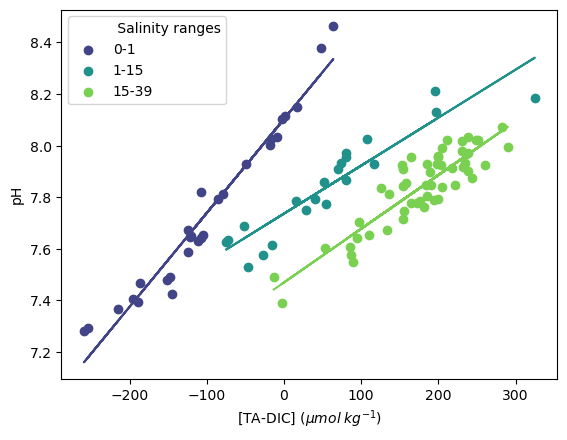

In [46]:
# Plot [TA-DIC] vs pH regression line for each salinity range

import matplotlib.cm as cm
from sklearn.linear_model import LinearRegression


# Define salinity levels
salinity_levels = [(0, 1), (1, 15), (15, 39)]

# Generate colors from the Viridis colormap
colors = cm.viridis([0.2, 0.5, 0.8])

# Function to fit model and return predictions
def fit_and_predict(X, y):
    model = LinearRegression()
    model.fit(X, y)
    return model.predict(X)

# Function to plot data and regression line
def plot_data_and_regression(X, y, pH_pred, color, label):
    plt.scatter(X, y, color=color, label=label)
    plt.plot(X, pH_pred, color=color)

# Function to process each salinity range
def process_salinity_range(sal_range):
    # Subset the data for the current salinity range
    subset = CarbonateTL.query(f"`Sal_psu` >= {sal_range[0]} & `Sal_psu` < {sal_range[1]}")
    
    # Reshape data for model input
    X = subset["TA-DIC"].values.reshape(-1, 1)
    y = subset["pH"].values
    
    # Fit the model and get predictions
    pH_pred = fit_and_predict(X, y)
    
    # Plot the data and the regression line
    plot_data_and_regression(X, y, pH_pred, colors[salinity_levels.index(sal_range)], f'{sal_range[0]}-{sal_range[1]}')

plt.plot([], [], ' ', label=" Salinity ranges")

# Apply the function to each salinity range
list(map(process_salinity_range, salinity_levels))


# Add labels and legend
plt.xlabel('[TA-DIC] ($\mu mol  \; kg^{-1}$)')

plt.ylabel('pH')
plt.legend()

# Show the plot
plt.show()

In [47]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

salinity_levels = [(0, 1), (1, 15), (15, 39)]

def fit_and_predict(X, y):
    model = LinearRegression()
    model.fit(X, y)
    pH_pred = model.predict(X)
    r2 = r2_score(y, pH_pred)
    return model.coef_[0], model.intercept_, r2

def print_results(sal_range, results):
    print(f"Salinity range: {sal_range[0]}-{sal_range[1]}")
    print(f"Slope: {results[0]}")
    print(f"Intercept: {results[1]}")
    print(f"R^2 score: {results[2]}")
    print("\n")

for sal_range in salinity_levels:
    subset = CarbonateTL[(CarbonateTL["Sal_psu"] >= sal_range[0]) & (CarbonateTL["Sal_psu"] < sal_range[1])]
    X = subset["TA-DIC"].values.reshape(-1, 1)
    y = subset["pH"].values
    results = fit_and_predict(X, y)
    print_results(sal_range, results)

Salinity range: 0-1
Slope: 0.003640309730454635
Intercept: 8.102661420495696
R^2 score: 0.9551512368757669


Salinity range: 1-15
Slope: 0.0018603831289462347
Intercept: 7.73617547073235
R^2 score: 0.8572044029812739


Salinity range: 15-39
Slope: 0.0020818713161796223
Intercept: 7.469347965311992
R^2 score: 0.7935145766514865




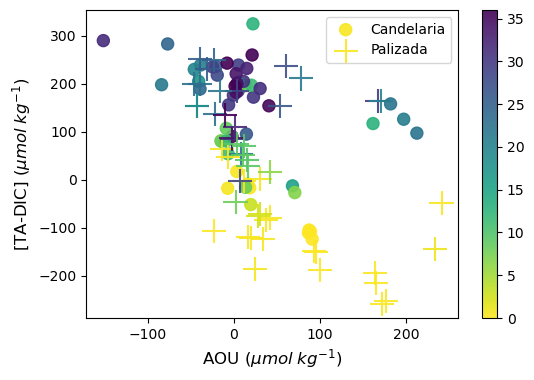

In [48]:
# Create the scatter plot 

# getting the original colormap using cm.get_cmap() function
orig_map = plt.colormaps.get_cmap('viridis')

# reversing the original colormap using reversed() function
reversed_map = orig_map.reversed()

scatter = plt.scatter(
    x=CandelariaResult["oxygen_utilization_micromol_kg"], y=CandelariaResult["TA-DIC"], c=CandelariaResult["Sal_psu"], cmap=reversed_map,
    marker='.', s= 300, label='Candelaria', alpha=0.9)


scatter = plt.scatter(
    x=PalizadaResult["oxygen_utilization_micromol_kg"], y=PalizadaResult["TA-DIC"] , c=PalizadaResult["Sal_psu"], cmap=reversed_map,
    marker='+', s= 300, label='Palizada', alpha=0.9)


# Add a color bar
plt.colorbar(scatter)


# Add labels and title
plt.xlabel("AOU ($\mu mol \; kg^{-1}$)", fontsize = 12)
plt.ylabel("[TA-DIC] ($\mu mol \; kg^{-1}$)" , fontsize = 12)
plt.legend(loc='upper right')

# set the figure size
plt.gcf().set_size_inches(6, 4)

# save the plot as a PDF file
plt.savefig('../output_files/AOU_TA-DIC_SAL.pdf', dpi=300, bbox_inches='tight')

# display the plot
plt.show()


# References
- Humphreys, M. P., Lewis, E. R., Sharp, J. D., & Pierrot, D. (2022). PyCO2SYS v1.8: Marine carbonate system calculations in Python. Geoscientific Model Development, 15(1), 15–43. https://doi.org/10.5194/gmd-15-15-2022
- Millero, F. J. (2010). Carbonate constants for estuarine waters. Marine and Freshwater Research, 61(2), 139. https://doi.org/10.1071/MF09254
- Wolf-Gladrow, D. A., Zeebe, R. E., Klaas, C., Körtzinger, A., & Dickson, A. G. (2007). Total alkalinity: The explicit conservative expression and its application to biogeochemical processes. Marine Chemistry, 106(1–2), 287–300. https://doi.org/10.1016/j.marchem.2007.01.006

_____________________